<a href="https://colab.research.google.com/github/jyryu3161/DrugDiscovery/blob/main/Lec11_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install python package

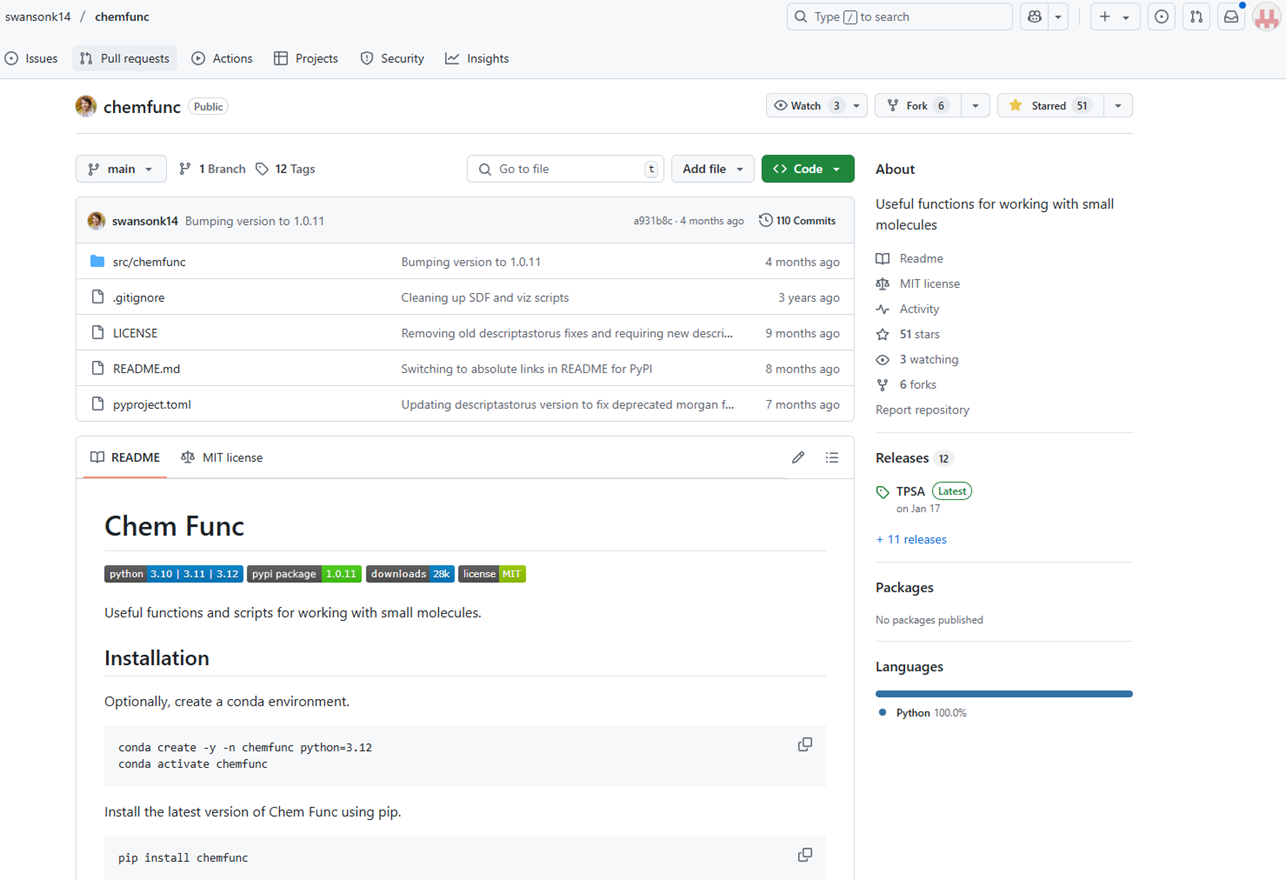

In [1]:
!pip install chemfunc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 74.2 MB/s eta 0:00:00


In [6]:
from pathlib import Path
from chemfunc.chemical_diversity import chemical_diversity
from chemfunc.select_from_clusters import select_from_clusters
from chemfunc.cluster_molecules import cluster_molecules

cluster_molecules(
    data_path=Path('./docking_results.csv'),
    save_path=Path('./docking_results_clustered.csv'),
    smiles_column="SMILES",
    num_clusters=50
)

select_from_clusters(
    data_path=Path('./docking_results_clustered.csv'),
    value_column='Vina Affinity (kcal/mol)',
    save_path=Path('./docking_results_clustered_selected.csv'),
    cluster_column="cluster_label",
    ascending=True
)


Loading data
Data size = 999
Computing Morgan fingerprints


morgan fingerprints: 100%|██████████| 999/999 [00:00<00:00, 10794.38it/s]

Clustering


Saving data
Original data size = 999
Final data size = 50


Loading data...
Total compounds: 999
Selected compounds: 50
Generating ECFP4 features...
Valid SMILES: 999
Performing t-SNE dimensionality reduction...


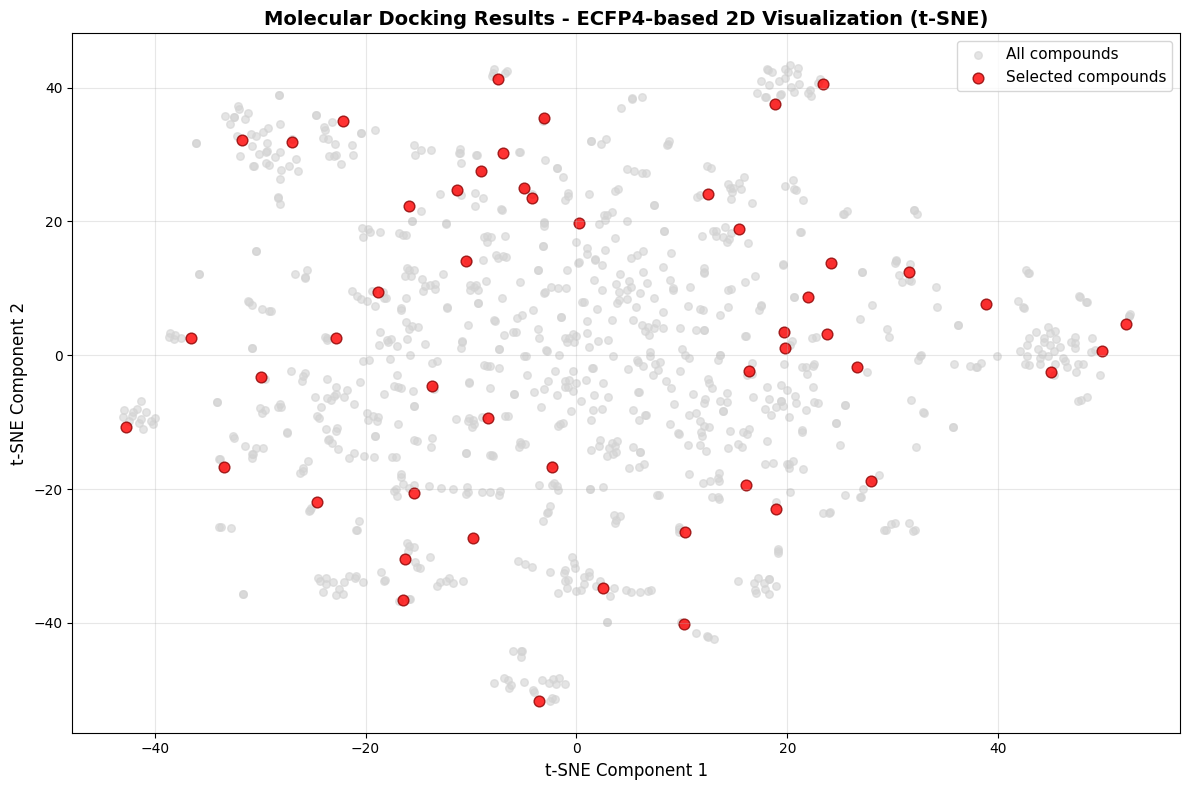

In [14]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
import os
import warnings

# RDKit 경고 억제
RDLogger.DisableLog('rdApp.*')  # RDKit의 모든 로그 비활성화

# Python 경고 억제 (RDKit 관련 경고 추가 필터링)
warnings.filterwarnings('ignore', category=UserWarning, module='rdkit')

# Font settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

def smiles_to_ecfp4(smiles, radius=2, nBits=1024):
    """Convert SMILES to ECFP4 fingerprint"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(fp)

def create_ecfp4_matrix(smiles_list):
    """Convert SMILES list to ECFP4 matrix"""
    fingerprints = []
    valid_indices = []

    for i, smiles in enumerate(smiles_list):
        fp = smiles_to_ecfp4(smiles)
        if fp.sum() > 0:  # Check if fingerprint is valid
            fingerprints.append(fp)
            valid_indices.append(i)
        else:
            print(f"Warning: Invalid SMILES at index {i}: {smiles}")

    return np.array(fingerprints), valid_indices

# Load data
print("Loading data...")
df_full = pd.read_csv('docking_results_clustered.csv')
df_selected = pd.read_csv('docking_results_clustered_selected.csv')

print(f"Total compounds: {len(df_full)}")
print(f"Selected compounds: {len(df_selected)}")

# Generate ECFP4 features
print("Generating ECFP4 features...")
X, valid_indices = create_ecfp4_matrix(df_full['SMILES'].tolist())

# Filter valid data only
df_full_valid = df_full.iloc[valid_indices].copy()
print(f"Valid SMILES: {len(df_full_valid)}")

# Dimensionality reduction (t-SNE)
print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Find indices of selected compounds
selected_smiles = set(df_selected['SMILES'].tolist())
is_selected = df_full_valid['SMILES'].isin(selected_smiles)

# Visualization
plt.figure(figsize=(12, 8))

# All compounds (gray)
plt.scatter(X_tsne[~is_selected, 0], X_tsne[~is_selected, 1],
           c='lightgray', alpha=0.6, s=30, label='All compounds')

# Selected compounds (red)
plt.scatter(X_tsne[is_selected, 0], X_tsne[is_selected, 1],
           c='red', alpha=0.8, s=60, label='Selected compounds', edgecolors='darkred')

plt.title('Molecular Docking Results - ECFP4-based 2D Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


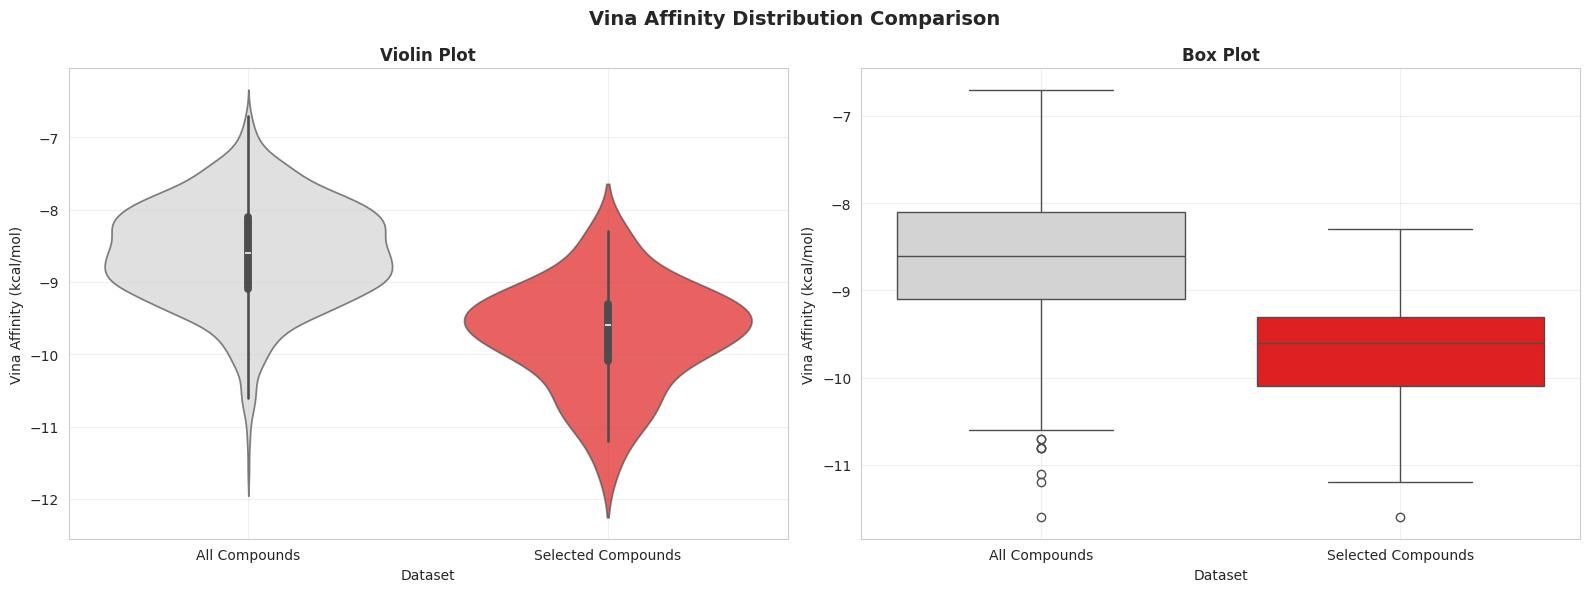

In [19]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Font and style settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

# Load data
df_full = pd.read_csv('docking_results_clustered.csv')
df_selected = pd.read_csv('docking_results_clustered_selected.csv')

# Create a combined dataset for violin plot
df_full['Dataset'] = 'All Compounds'
df_selected['Dataset'] = 'Selected Compounds'

# Combine datasets
df_combined = pd.concat([df_full, df_selected], ignore_index=True)


# 5. Box plot + violin plot combination
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Violin plot
sns.violinplot(data=df_combined, x='Dataset', y='Vina Affinity (kcal/mol)',
               palette=['lightgray', 'red'], alpha=0.7, ax=ax1)
ax1.set_title('Violin Plot', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Box plot
sns.boxplot(data=df_combined, x='Dataset', y='Vina Affinity (kcal/mol)',
            palette=['lightgray', 'red'], ax=ax2)
ax2.set_title('Box Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('Vina Affinity Distribution Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
